In [9]:
import math
import random
import pygame
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# Custom Environment
class MoonWorldEnv(gym.Env):
    def __init__(self):
        super(MoonWorldEnv, self).__init__()
        self.grid_size = 8
        self.moon_location = (7, 7)
        self.meteor_states = [(5, 5), (7, 5), (1, 5), (4, 3), (2, 3), (4, 7)]
        self.holes = [(0, 2), (1, 7), (3, 5), (4, 1), (6, 3)]
        self.meteors = self.meteor_states
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=self.grid_size-1, shape=(2,), dtype=np.int32)
        self.window_size = 700
        self.cell_size = self.window_size // self.grid_size
        pygame.init()     
        self.screen = pygame.display.set_mode((self.window_size, self.window_size))
        pygame.display.set_caption('MoonWorld Environment')
        self.clock = pygame.time.Clock()
        self.background_img = pygame.image.load('background.jpg')
        self.background_img = pygame.transform.scale(self.background_img, (self.window_size, self.window_size))
        self.rocket_img = pygame.image.load('rocket.png')
        self.rocket_img = pygame.transform.scale(self.rocket_img, (self.cell_size, self.cell_size))
        self.moon_img = pygame.image.load('moon.png')
        self.moon_img = pygame.transform.scale(self.moon_img, (self.cell_size, self.cell_size))
        self.meteor_img = pygame.image.load('meteor.png')
        self.meteor_img = pygame.transform.scale(self.meteor_img, (self.cell_size, self.cell_size))

    def reset(self):
        self.agent_position = [0, 0]
        self.history = [self.agent_position.copy()]
        self.fuel = 20
        distance_to_moon = self.calculate_distance(self.agent_position, self.moon_location)
        info = {'distance_to_moon': distance_to_moon, 'fuel': self.fuel}
        return np.array(self.agent_position), info

    def step(self, action):
        prev_position = self.agent_position.copy()
        new_position = self.agent_position.copy()
        
        if action == 0 and self.agent_position[1] > 0:  # Up
            new_position[1] -= 1
        elif action == 1 and self.agent_position[1] < self.grid_size - 1:  # Down
            new_position[1] += 1
        elif action == 2 and self.agent_position[0] > 0:  # Left
            new_position[0] -= 1
        elif action == 3 and self.agent_position[0] < self.grid_size - 1:  # Right
            new_position[0] += 1

        if tuple(new_position) not in self.holes:
            self.agent_position = new_position

        self.history.append(self.agent_position.copy())
        self.fuel -= 1

        done = False
        reward = 0

        distance_to_moon = self.calculate_distance(self.agent_position, self.moon_location)
        
        if tuple(self.agent_position) == self.moon_location:
            reward = 100
            done = True
        elif tuple(self.agent_position) in self.meteors:
            reward = -50
            done = True
        elif self.fuel <= 0:
            reward = -10
            done = True
        else:
            #Fuel consumption penalty
            reward = -1
            
            # Penalty for moving away from the moon
            if distance_to_moon > self.calculate_distance(prev_position, self.moon_location):
                reward -= 1
            
            # Fuel consumption reward
            if self.fuel > 0:
                reward += 0.5
            
            # Penalty for moving towards meteors or holes
            if tuple(self.agent_position) in self.meteors or tuple(self.agent_position) in self.holes:
                reward -= 5
        
        info = {'distance_to_moon': distance_to_moon, 'fuel': self.fuel}

        return np.array(self.agent_position), reward, done, info


    def calculate_distance(self, pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

    def render(self, mode='human', tick_rate=10):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()

        self.screen.fill((255, 255, 255))
        self.screen.blit(self.background_img, (0, 0))

        for x in range(0, self.window_size, self.cell_size):
            for y in range(0, self.window_size, self.cell_size):
                rect = pygame.Rect(x, y, self.cell_size, self.cell_size)
                pygame.draw.rect(self.screen, (0, 0, 0), rect, 1)

        self.screen.blit(self.rocket_img, (self.agent_position[0] * self.cell_size, self.agent_position[1] * self.cell_size))
        self.screen.blit(self.moon_img, (self.moon_location[0] * self.cell_size, self.moon_location[1] * self.cell_size))

        for meteor in self.meteor_states:
            self.screen.blit(self.meteor_img, (meteor[0] * self.cell_size, meteor[1] * self.cell_size))

        for hole in self.holes:
            hole_rect = pygame.Rect(
                hole[0] * self.cell_size,
                hole[1] * self.cell_size,
                self.cell_size,
                self.cell_size
            )
            pygame.draw.rect(self.screen, (0, 0, 0), hole_rect)

        pygame.display.flip()
        self.clock.tick(tick_rate)  # Adjusted tick rate for slower rendering

    def close(self):
        pygame.quit()

In [10]:
# Q-learning Agent for MoonWorldEnv
class QLearningAgent:
    def __init__(self, action_space, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay  
        self.epsilon_min = epsilon_min  
        self.q_table = {}

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def update_q_value(self, state, action, reward, next_state):
        best_next_q = max([self.get_q_value(next_state, a) for a in range(self.action_space.n)])
        td_target = reward + self.discount_factor * best_next_q
        td_error = td_target - self.get_q_value(state, action)
        self.q_table[(state, action)] = self.get_q_value(state, action) + self.learning_rate * td_error

    def choose_action(self, state, env):
        if random.uniform(0, 1) < self.epsilon:
            return env.action_space.sample()  # Explore action space
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.action_space.n)]
            return np.argmax(q_values)  # Exploit learned values

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_q_table(self, file_path):
        np.save(file_path, self.q_table)

    def get_q_table(self):
        return self.q_table

    def print_q_table(self):
        for state_action, value in self.q_table.items():
            print(f"State {state_action[0]} Action {state_action[1]}: Q-value = {value}")

    def get_optimal_policy(self):
        optimal_policy = {}
        for state_action in self.q_table.keys():
            state = state_action[0]
            action = state_action[1]
            if state not in optimal_policy:
                optimal_policy[state] = (action, self.q_table[state_action])
            else:
                if self.q_table[state_action] > optimal_policy[state][1]:
                    optimal_policy[state] = (action, self.q_table[state_action])
        return optimal_policy

    def print_optimal_policy(self):
        optimal_policy = self.get_optimal_policy()
        for state, action_value in optimal_policy.items():
            print(f"State {state}: Best Action = {action_value[0]}, Q-value = {action_value[1]}")


In [11]:
def main():
    env = MoonWorldEnv()
    agent = QLearningAgent(env.action_space)

    episodes = 50000
    for episode in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        total_reward = 0

        while True:
            action = agent.choose_action(state, env)
            next_obs, reward, done, _ = env.step(action)
            next_state = tuple(next_obs)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
            total_reward += reward

            if done:
                break

        agent.decay_epsilon()  # Decay epsilon after each episode

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon}")

    # Save Q-table
    agent.save_q_table('q_table.npy')

    # Print Q-table and optimal policy
    print("Q-table:")
    agent.print_q_table()
    print("\nOptimal Policy:")
    agent.print_optimal_policy()

    # Testing (10 episodes) with slower visualization
    for _ in range(10):
        obs, info = env.reset()
        while True:
            state = tuple(obs)
            action = agent.choose_action(state, env)
            obs, reward, done, info = env.step(action)
            env.render(tick_rate=5)  # Adjust tick_rate as needed for slower rendering

            if done:
                break

    env.close()

# Visualize the Q-table
def visualize_q_table(q_values_path):
    """
    Visualize the trained Q-table.

    Args:
        q_values_path (str): Path to the Q-table file.
    """
    q_table = np.load(q_values_path, allow_pickle=True).item()

    grid_size = 8
    action_space = 4
    Q = np.zeros((grid_size, grid_size, action_space))

    for (state, action), value in q_table.items():
        Q[state[0], state[1], action] = value

    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    actions = ['Up', 'Down', 'Left', 'Right']

    Q = Q.transpose((1, 0, 2))

    for i in range(4):
        row = i // 2
        col = i % 2
        cax = ax[row, col].matshow(Q[:, :, i], cmap='viridis')

        for x in range(grid_size):
            for y in range(grid_size):
                ax[row, col].text(y, x, f'{Q[x, y, i]:.2f}', va='center', ha='center', color='white')

        fig.colorbar(cax, ax=ax[row, col])
        ax[row, col].set_title(f'Q-value for action: {actions[i]}')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Episode 100/50000, Total Reward: -63.0, Epsilon: 0.9047921471137096
Episode 200/50000, Total Reward: -57.0, Epsilon: 0.818648829478636
Episode 300/50000, Total Reward: -22.5, Epsilon: 0.7407070321560997
Episode 400/50000, Total Reward: -23.5, Epsilon: 0.6701859060067403
Episode 500/50000, Total Reward: -25.5, Epsilon: 0.6063789448611848
Episode 600/50000, Total Reward: -25.5, Epsilon: 0.5486469074854965
Episode 700/50000, Total Reward: -21.5, Epsilon: 0.4964114134310989
Episode 800/50000, Total Reward: -22.5, Epsilon: 0.4491491486100748
Episode 900/50000, Total Reward: -53.5, Epsilon: 0.4063866225452039
Episode 1000/50000, Total Reward: -52.5, Epsilon: 0.3676954247709635
Episode 1100/50000, Total Reward: -53.5, Epsilon: 0.33268793286240766
Episode 1200/50000, Total Reward: -21.5, Epsilon: 0.3010134290933992
Episode 1300/50000, Total Reward: 93.0, Epsilon: 0.27235458681947705
Episode 1400/50000, Total Reward: 91.5, Epsilon: 0.24642429138466176
Episode 1500/50000, Total Reward: -55.0, Ep

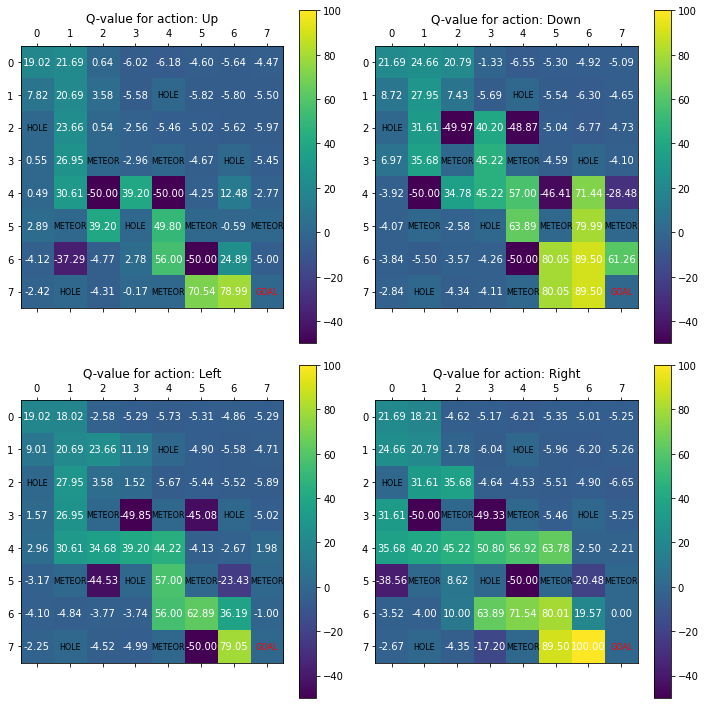

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_q_table(q_values_path):
    """
    Visualize the trained Q-table.

    Args:
        q_values_path (str): Path to the Q-table file.
    """
    q_table = np.load(q_values_path, allow_pickle=True).item()

    grid_size = 8  # Assuming an 8x8 grid
    action_space = 4
    Q = np.zeros((grid_size, grid_size, action_space))

    # Update Q-values from q_table
    for (state, action), value in q_table.items():
        Q[state[0], state[1], action] = value

    # Transpose the Q-table for correct visualization
    Q = Q.transpose((1, 0, 2))

    # Define which states are "hell" states (just an example)
    meteors = [(5, 5), (7, 5), (1, 5), (4, 3), (2, 3), (4, 7)]
    meteors = [(y, x) for (x, y) in meteors]
    
    holes = [(0, 2), (1, 7), (3, 5), (4, 1), (6, 3)]
    holes = [(y, x) for (x, y) in holes]

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    actions = ['Up', 'Down', 'Left', 'Right']

    for i, action in enumerate(actions):
        row = i // 2
        col = i % 2
        cax = ax[row, col].matshow(Q[:, :, i], cmap='viridis', vmin=np.min(Q), vmax=np.max(Q))

        for x in range(grid_size):
            for y in range(grid_size):
                if (x, y) in meteors:
                    ax[row, col].text(y, x, 'METEOR', va='center', ha='center', color='black', fontsize=8)
                elif (x, y) in [(7,7)]:
                    ax[row, col].text(y, x, 'GOAL', va='center', ha='center', color='red', fontsize=8)
                elif (x, y) in holes:
                    ax[row, col].text(y, x, 'HOLE', va='center', ha='center', color='black', fontsize=8)
                else:
                    ax[row, col].text(y, x, f'{Q[x, y, i]:.2f}', va='center', ha='center', color='white')

        fig.colorbar(cax, ax=ax[row, col])
        ax[row, col].set_title(f'Q-value for action: {action}')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    visualize_q_table('q_table.npy')


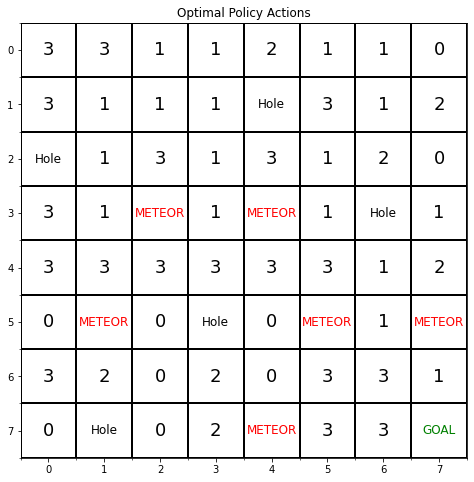

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_optimal_policy(q_values_path):
    """
    Visualize the optimal policy derived from the Q-table.

    Args:
        q_values_path (str): Path to the Q-table file.
    """
    q_table = np.load(q_values_path, allow_pickle=True).item()

    grid_size = 8
    action_space = 4
    optimal_policy = np.zeros((grid_size, grid_size), dtype=int)
   

    # Update optimal policy based on Q-table values
    for (state, action), value in q_table.items():
        if value > q_table.get((state, optimal_policy[state[0], state[1]]), float('-inf')):
            optimal_policy[state[0], state[1]] = action

    fig, ax = plt.subplots(figsize=(8, 8))

    for x in range(grid_size):
        for y in range(grid_size):
            action = optimal_policy[y, x]
            # Display action with a marker for special states
            if (y, x) in [(5, 5), (7, 5), (1, 5), (4, 3), (2, 3), (4, 7)]:
                ax.text(y, x, 'METEOR', ha='center', va='center', fontsize=12, color='red')
            elif (x, y) == (7, 7):  # Example goal state
                ax.text(y, x, 'GOAL', ha='center', va='center', fontsize=12, color='green')
            elif (y, x) in [(0, 2), (1, 7), (3, 5), (4, 1), (6, 3)]:
                ax.text(y, x, 'Hole', ha='center', va='center', fontsize=12, color='black')
            else:
                ax.text(y, x, action, ha='center', va='center', fontsize=18)

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels(np.arange(grid_size))
    ax.set_yticklabels(np.arange(grid_size))

    # Draw grid lines
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    plt.title('Optimal Policy Actions')
    plt.gca().invert_yaxis()
    plt.show()

if __name__ == "__main__":
    visualize_optimal_policy('q_table5000000.npy')


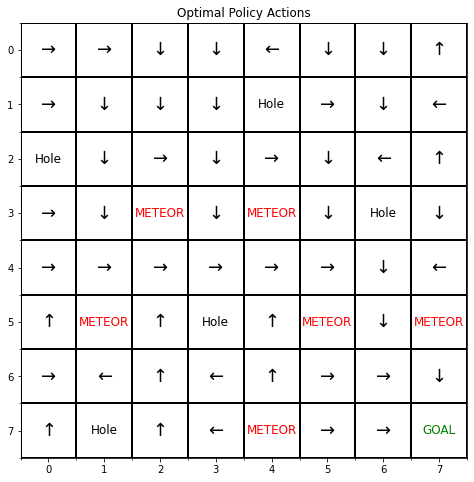

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_optimal_policy(q_values_path):
    """
    Visualize the optimal policy derived from the Q-table.

    Args:
        q_values_path (str): Path to the Q-table file.
    """
    q_table = np.load(q_values_path, allow_pickle=True).item()

    grid_size = 8
    action_space = 4
    optimal_policy = np.zeros((grid_size, grid_size), dtype=int)
   
    # Mapping actions to arrow symbols
    action_to_arrow = {
        0: '↑',  # Up
        3: '→',  # Right
        1: '↓',  # Down
        2: '←'   # Left
    }

    # Update optimal policy based on Q-table values
    for (state, action), value in q_table.items():
        if value > q_table.get((state, optimal_policy[state[0], state[1]]), float('-inf')):
            optimal_policy[state[0], state[1]] = action

    fig, ax = plt.subplots(figsize=(8, 8))

    for x in range(grid_size):
        for y in range(grid_size):
            action = optimal_policy[y, x]
            if (y, x) in [(5, 5), (7, 5), (1, 5), (4, 3), (2, 3), (4, 7)]:
                ax.text(y, x, 'METEOR', ha='center', va='center', fontsize=12, color='red')
            elif (x, y) == (7, 7):  # Example goal state
                ax.text(y, x, 'GOAL', ha='center', va='center', fontsize=12, color='green')
            elif (y, x) in [(0, 2), (1, 7), (3, 5), (4, 1), (6, 3)]:
                ax.text(y, x, 'Hole', ha='center', va='center', fontsize=12, color='black')
            else:
                ax.text(y, x, action_to_arrow[action], ha='center', va='center', fontsize=18)

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels(np.arange(grid_size))
    ax.set_yticklabels(np.arange(grid_size))

    # Draw grid lines
    ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    plt.title('Optimal Policy Actions')
    plt.gca().invert_yaxis()
    plt.show()

if __name__ == "__main__":
    visualize_optimal_policy('q_table5000000.npy')
